# Setup and Data Loading

Importing necessary libraries Pandas for data manipulation, NumPy for numerical operations, Matplotlib and Seaborn for plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # For splitting the data into train and test sets
from sklearn.preprocessing import StandardScaler, LabelEncoder # For feature scaling and encoding labels
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Import ensemble models for classification
from sklearn.linear_model import LogisticRegression # Import logistic regression model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Metrics to evaluate the model
from sklearn.model_selection import cross_val_score # For performing cross-validation

# Ensuring that matplotlib graphs are included in the output cell directly
%matplotlib inline

# Data Preprocessing

This is to handle any necessary data cleaning tasks such as dealing with missing values, encoding categorical variables, and normalizing numerical data.

In [2]:
# Load the dataset into a pandas DataFrame
data = pd.read_csv('UNSW_NB15_training-set (1).csv')

# Display the first few rows to understand the data's structure
print(data.head())

# Display detailed information about the dataset to identify columns, data types, and null values
print(data.info())

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [5]:
# Preprocessing steps
# Filter out rows where 'service' column has '-' which are treated as missing values
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
data_filtered = data[data['service'] != '-']

# Identifying categorical and numerical columns for further preprocessing
categorical_cols = ['proto', 'service', 'state', 'attack_cat']
numerical_cols = [col for col in data_filtered.columns if col not in categorical_cols + ['label', 'id']]

# Set up pipelines for transforming numerical and categorical data
# StandardScaler normalizes numerical data, and OneHotEncoder converts categorical data into binary features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Creating a transformer for categorical attributes
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the ColumnTransformer to the DataFrame
data_prepared = preprocessor.fit_transform(data_filtered.drop(['label', 'id'], axis=1))

# Encoding the target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(data_filtered['label'])

print("Data preprocessing complete. Rows with '-' in 'service' column have been removed.")


Data preprocessing complete. Rows with '-' in 'service' column have been removed.


# Exploratory Data Analysis (EDA)

Here we'll focus on visualizing different aspects of the data, including the distribution of key features and the relationships.

{0: 19488, 1: 61685}


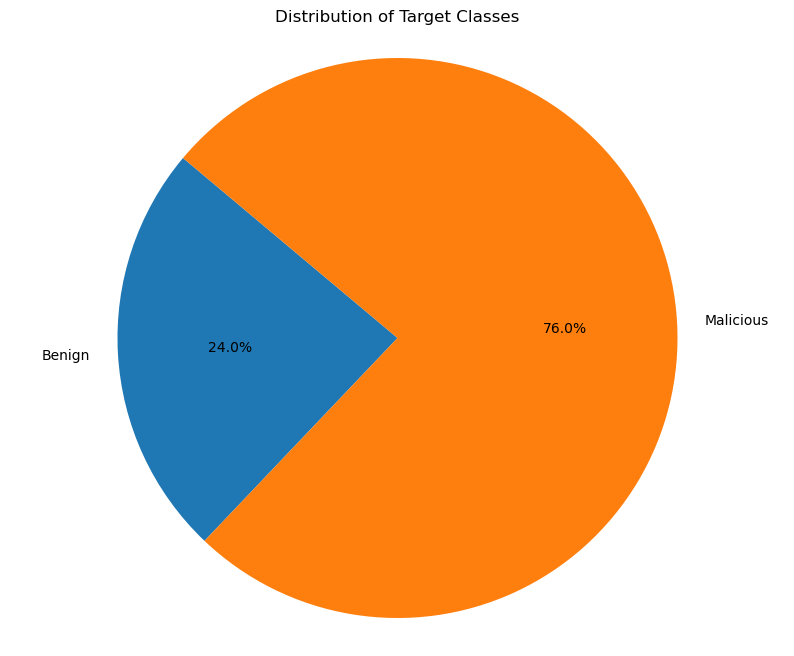

In [29]:
# Visualization Section
# Visualize the distribution of the target classes to understand class balance
# Count the number of instances for each target class
unique, counts = np.unique(target_encoded, return_counts=True)
target_counts = dict(zip(unique, counts))
print(target_counts)

# Manually specify class labels
class_labels = ['Benign', 'Malicious']

# Plotting the pie chart
plt.figure(figsize=(10, 8))  # Set the figure size

# Create the pie chart with manually assigned labels
plt.pie(list(target_counts.values()), labels=class_labels, autopct='%1.1f%%', startangle=140)

# Adding title
plt.title('Distribution of Target Classes')

# Ensure the pie chart is drawn as a circle
plt.axis('equal')

# Showing the plot
plt.show()

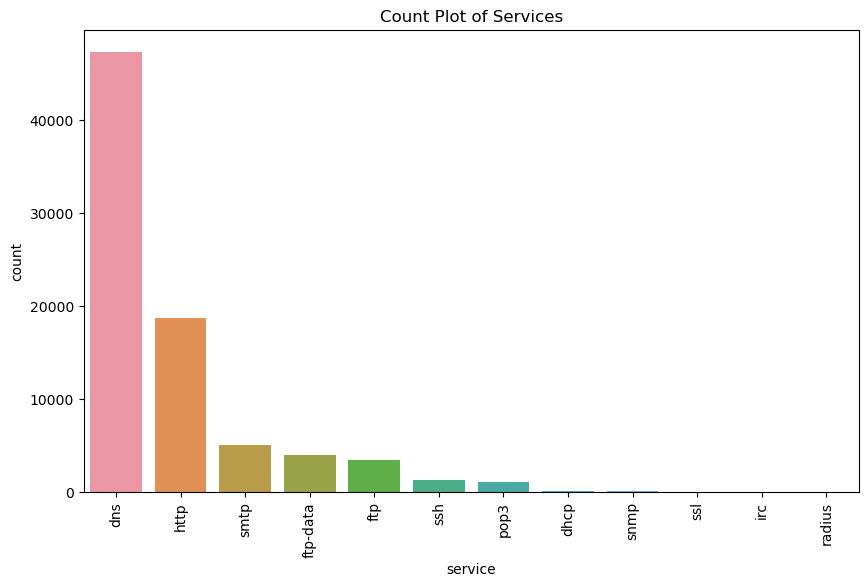

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='service', data=data_filtered, order=data_filtered['service'].value_counts().index)
plt.title('Count Plot of Services')
plt.xticks(rotation=90)
plt.show()


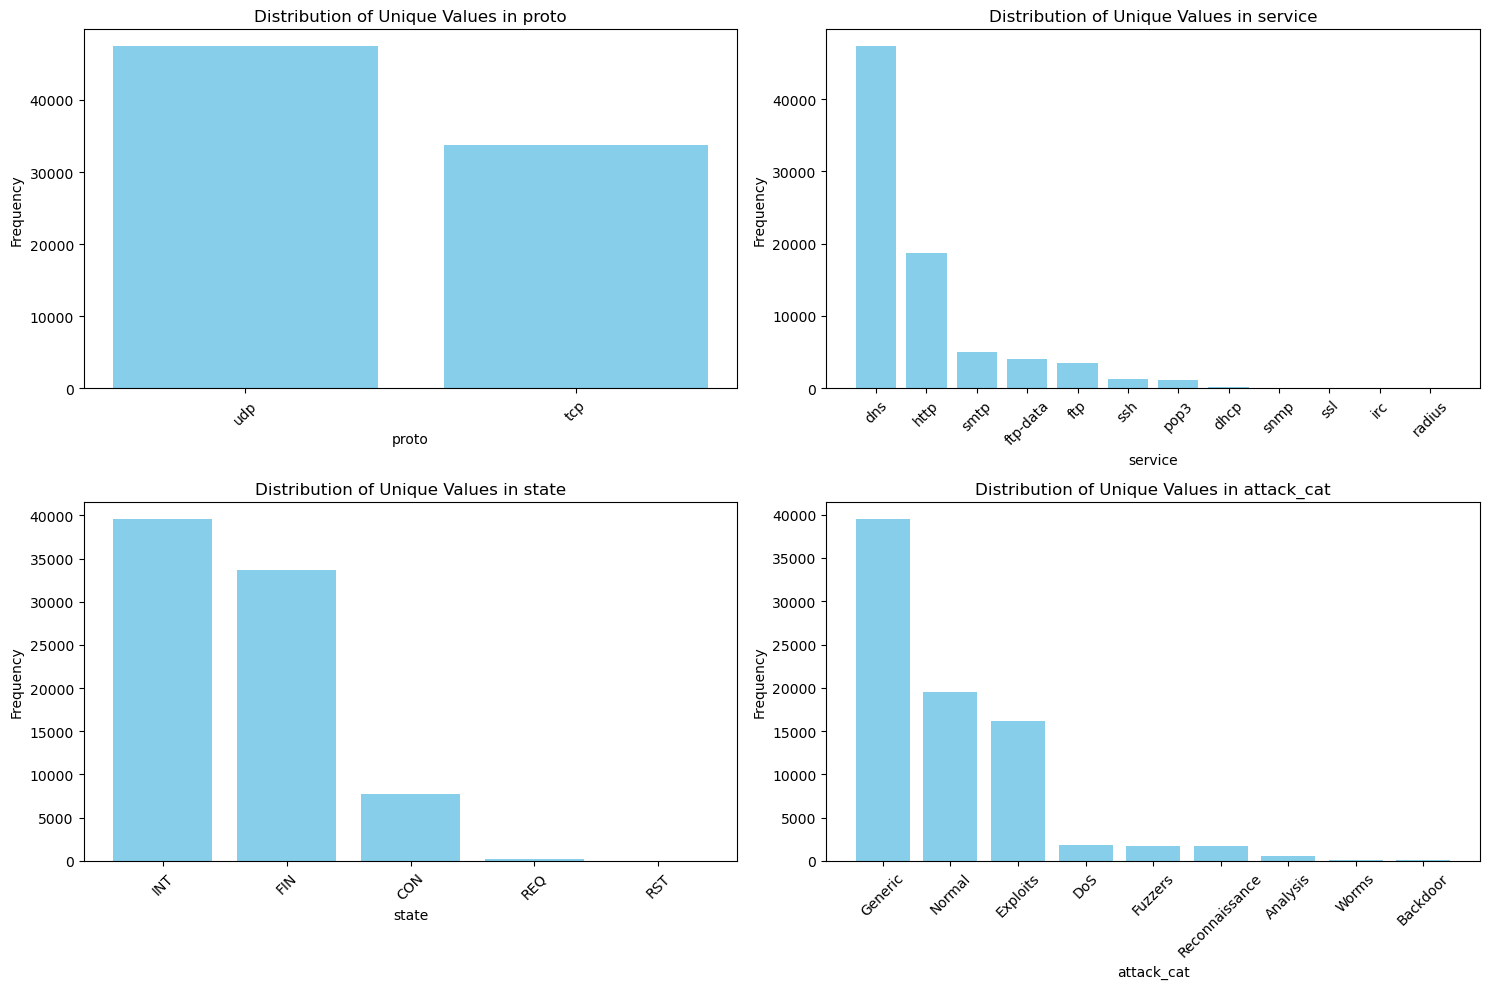

In [42]:
n_cols = 2  # Number of columns in the subplot grid
n_rows = 2  # Number of rows in the subplot grid

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration if it's 2D (for n_rows > 1)
axes = axes.flatten()

# Loop through each categorical column and plot
for idx, col in enumerate(categorical_cols):
    # Calculate the value counts for the current categorical column
    value_counts = data_filtered[col].value_counts()
    
    # Create the bar chart in the specified subplot
    axes[idx].bar(value_counts.index, value_counts.values, color='skyblue')
    
    # Set title for the current categorical column
    axes[idx].set_title(f'Distribution of Unique Values in {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    
    # Rotate the x-axis labels for better visibility
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()

C:\Users\SATYA NAVEEN\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


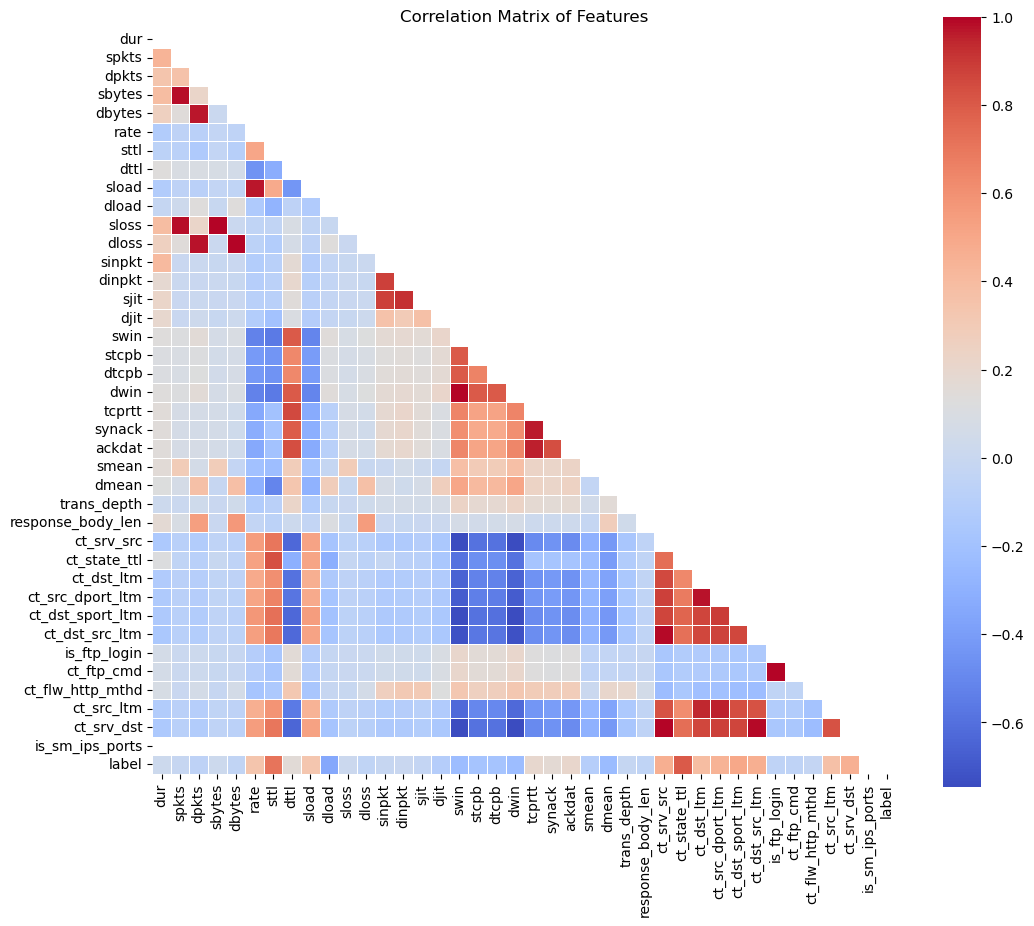

In [36]:
# Compute and visualize the correlation matrix to understand relationships between features
corr_matrix = data_filtered[numerical_cols + ['label']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()


1. Distribution of Target Classes: The class distribution plot shows significant imbalance between the two classes. This will need to be considered during model training to prevent bias towards the majority class.
2. 
Histograms of Numerical Features: These histograms reveal that many numerical features are heavily skewed, with most values clustered near the lower end of the range. This suggests that transformations such as logarithmic scaling might be needed to normalize these distributions
3. 
Correlation Matrix: The heatmap of the correlation matrix is useful for identifying relationships between features. Some features exhibit high correlation, which might lead to multicollinearity if used together in some types of models.

# Model Development and Evaluation

We might want to compare the performance of different models. Typical choices could include Logistic Regression, Decision Trees, Support Vector Machines, Gradient Boosting and Gaussian Navie Bayes. Evaluating each using cross-validation can help determine which model performs best.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Setup and evaluate multiple classifiers including Logistic Regression, Decision Trees, Gradient Boosting, and Naive Bayes
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(class_weight=class_weights),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
}

# Results dictionary to store model performance
results = {}


In [21]:
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    results[name] = {
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred),
        "Accuracy": accuracy
    }

Logistic Regression - Accuracy: 1.0
Decision Tree - Accuracy: 1.0
Random Forest - Accuracy: 1.0
Gradient Boosting - Accuracy: 1.0
Gaussian Naive Bayes - Accuracy: 1.0


In [53]:
# Perform cross-validation for all models to ensure robustness and generalizability
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, data_prepared, target_encoded, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name} - Cross-validation scores: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression - Cross-validation scores: 0.9999 ± 0.0003
Decision Tree - Cross-validation scores: 1.0000 ± 0.0000
Random Forest - Cross-validation scores: 1.0000 ± 0.0000
Gradient Boosting - Cross-validation scores: 1.0000 ± 0.0000
Gaussian Naive Bayes - Cross-validation scores: 0.9999 ± 0.0001


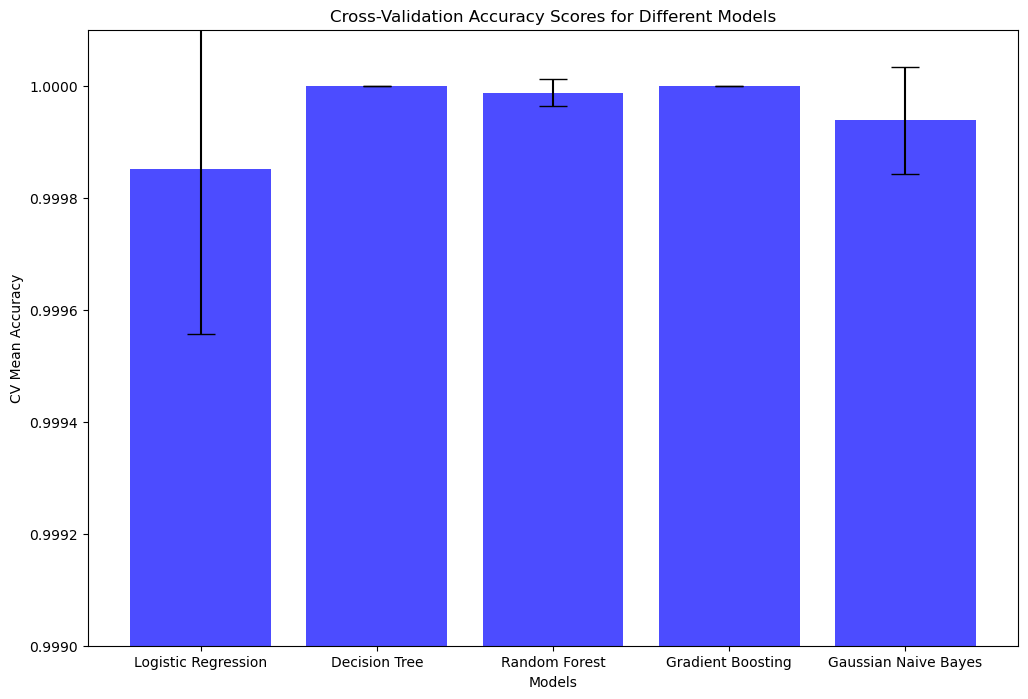

In [54]:
# Visualize cross-validation results to compare model performance
model_names = list(cv_results.keys())

# Mean of cross-validation scores
cv_means = [scores.mean() for scores in cv_results.values()]

# Standard deviation of cross-validation scores
cv_stds = [scores.std() for scores in cv_results.values()]

# Creating the bar plot with error bars
plt.figure(figsize=(12, 8))
plt.bar(model_names, cv_means, yerr=cv_stds, alpha=0.7, color='b', capsize=10)
plt.xlabel('Models')
plt.ylabel('CV Mean Accuracy')
plt.title('Cross-Validation Accuracy Scores for Different Models')
plt.ylim(0.9990, 1.0001)  # Adjusting the y-axis limits to better visualize the error bars
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Model Training and Evaluation
# Random Forest with class weight adjustments to handle class imbalance
class_weights = {0: 1, 1: len(data_filtered[data_filtered['label'] == 0]) / len(data_filtered[data_filtered['label'] == 1])}
rf_model = RandomForestClassifier(class_weight=class_weights)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_prepared, target_encoded, test_size=0.2, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[ 3865     0]
 [    0 12370]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3865
           1       1.00      1.00      1.00     12370

    accuracy                           1.00     16235
   macro avg       1.00      1.00      1.00     16235
weighted avg       1.00      1.00      1.00     16235



Based on the cross-validation results and the visual comparison:
1. 
Decision Tree, Random Forest, and Gradient Boosting all show perfect accuracy with minimal variability. These models are highly effective for your dataset but might be considered overqualified, depending on their complexity and the cost of computatio
2. .
Logistic Regression offers slightly less stability (though still very high performance), which could be a sign of it being less complex and potentially more generalizable to unseen da

The Logistic Regression model shows a slightly greater variability in cross-validation scores compared to the Decision Tree, Random Forest, and Gradient Boosting models, which exhibit almost perfect and consistent performance. Gradient Boosting is a powerful machine learning algorithm known for its high accuracy and ability to handle various types of data. So let's opt for Gradient Boosting.ta.

# Model Tuning and Finalization

Here’s how we could proceed with a model like Gradient Boosting:
1. Hyperparameter Tuning: Use grid search or random search to find the optimal settings for hyperparameters.
2. Feature Importance Analysis: Analyze the importance of different features in the model, which can also help in reducing model complexity.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define a smaller parameter grid
param_grid = {
    'n_estimators': [100, 150],  # fewer estimators
    'learning_rate': [0.1, 0.2],  # focus on commonly used learning rates
    'max_depth': [3, 5],  # limit depth to prevent complex trees
    'min_samples_split': [2],  # fewer splits
    'min_samples_leaf': [1, 2]  # minimal leaf samples
}

# Initialize the GradientBoosting classifier
gb = GradientBoostingClassifier()

# Initialize the GridSearchCV object with fewer CV folds
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.00


In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the RandomizedSearchCV object with fewer iterations and CV folds
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', verbose=1, random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score from RandomizedSearchCV
print("Best parameters from Randomized Search:", random_search.best_params_)
print("Best cross-validation score from Randomized Search: {:.2f}".format(random_search.best_score_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters from Randomized Search: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation score from Randomized Search: 1.00


In [31]:
# Test with a basic setup
simple_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
simple_gb.fit(X_train, y_train)
simple_pred = simple_gb.predict(X_test)
print("Accuracy with simple setup:", accuracy_score(y_test, simple_pred))


Accuracy with simple setup: 1.0


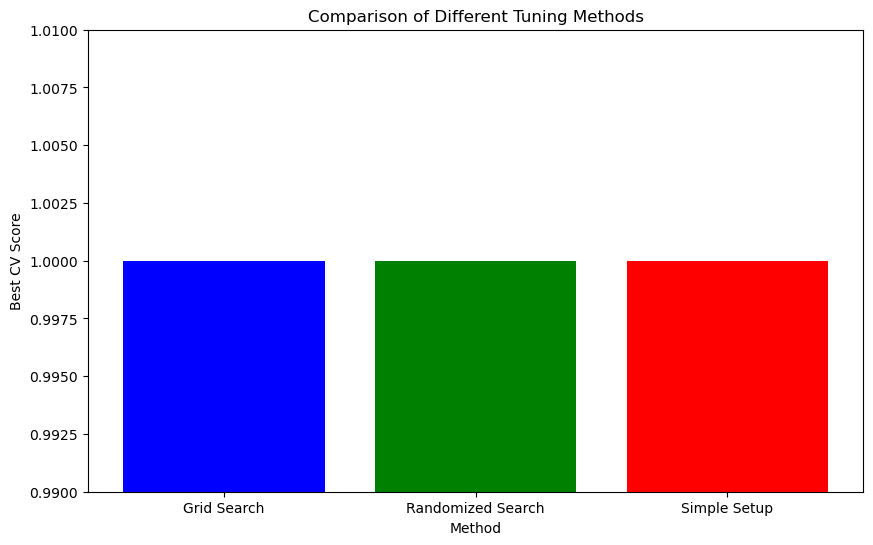

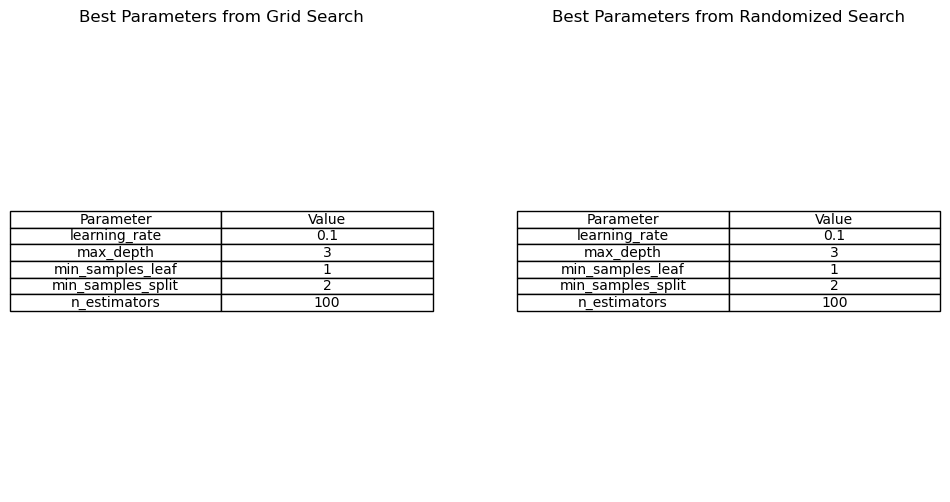

In [43]:
import matplotlib.pyplot as plt

# Data for plotting
methods = ['Grid Search', 'Randomized Search', 'Simple Setup']
scores = [1.00, 1.00, 1.0]  # Assuming all scores are perfect

# Creating bar chart for cross-validation scores
plt.figure(figsize=(10, 6))
plt.bar(methods, scores, color=['blue', 'green', 'red'])
plt.xlabel('Method')
plt.ylabel('Best CV Score')
plt.title('Comparison of Different Tuning Methods')
plt.ylim(0.99, 1.01)  # Adjust y-limit to zoom in on the score differences
plt.show()

# Details of best parameters
best_params_grid = {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_random = {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Function to display parameters in a table-like format
def display_params(ax, params, title):
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=list(params.items()), colLabels=['Parameter', 'Value'], cellLoc = 'center', loc='center')
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

display_params(axs[0], best_params_grid, 'Best Parameters from Grid Search')
display_params(axs[1], best_params_random, 'Best Parameters from Randomized Search')

plt.show()


# Deployment Preparation

In [42]:
import joblib

# Assuming `grid_search.best_estimator_` is your best model
best_model = grid_search.best_estimator_

# Serialize the model
joblib.dump(best_model, 'final_gradient_boosting_model.joblib')

print("Model has been saved successfully.")


Model has been saved successfully.
